# Cracking the Code: Which Ads Actually Bring in Paying Players for Our Mobile Game?

In the competitive world of mobile gaming, a download is just the beginning. The real challenge is identifying which advertising efforts attract players who become **valuable, paying customers**.

This analysis dives into **8 recent advertising campaigns (Campaigns A-H)** to move beyond simple download counts. Our initial objective: measure **short-term efficiency**: which campaigns could bring in new paying users for under a **\$50 Cost Per Payer (CPP)** within their first **7 days**?

As we uncovered, the story is more **nuanced**. Our findings reveal a **critical tension between short-term efficiency and long-term value**, highlighting the limitations of simple attribution and the need for a more sophisticated view. This analysis identifies our most efficient campaigns and provides a **data-driven roadmap** for future budget allocation, funnel optimization, and strategic testing.

## Table of Contents

0. [Data Preparation & Setup](#data-prep)
1. [Short-Term Efficiency: A First Look at Campaign Performance](#task1)
2. [The Bigger Picture: Funnel Analysis and Long-Term Value](#task2)
3. [Statistical Validation: Ensuring Our Insights are Real](#task3)
4. [Strategic Experimentation: Designing an A/B Test](#task4)
5. [Cohort Deep Dive: Tracking Player Value with SQL](#task5)
6. [Strategic Insights & Actionable Recommendations](#conclusions)

<a id='data-prep'></a>
## Inroduction: Preparing Our Tools and Getting the Data Ready

Before uncovering insights, we prepared our analytical environment. This involved setting up our workspace with necessary Python libraries for data manipulation (pandas), statistical analysis (scipy), and visualization (matplotlib, seaborn).

In [1]:
# Libs
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize

import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3
from datetime import datetime, timedelta

from google.colab import drive
drive.mount('/content/drive')

# Plots
sns.set_palette('pastel')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.figsize': (12, 6)
})

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


Next, we loaded and integrated our datasets, connecting user registration data from ad platforms with in-game payment and activity logs. This created a **unified view of the user journey**, from initial acquisition to monetization.

In [2]:
registration_df = 'content/drive/.../registration.csv'
payment_df = '/content/drive/.../payment.csv'
tutorial_df = '/content/drive/.../tutorial.csv'
ad_data_df = '/content/drive/.../ad_data.csv'

In [3]:
registration = pd.read_csv(registration_df)
payment = pd.read_csv(payment_df)
tutorial = pd.read_csv(tutorial_df)
ad_data = pd.read_csv(ad_data_df)

print("Dataset Overview:")
print(f"Registration data: {registration.shape[0]:,} rows")
print(f"Payment data: {payment.shape[0]:,} rows")
print(f"Tutorial data: {tutorial.shape[0]:,} rows")
print(f"Ad campaign data: {ad_data.shape[0]:,} rows")

date_columns = ['date']
for df in [registration, payment, ad_data]:
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

registration['reg_ts'] = registration['ts'] = pd.to_datetime(registration['ts'], unit='s')
tutorial['tut_ts'] = tutorial['ts'] = pd.to_datetime(tutorial['ts'], unit='s')
payment['pay_ts'] = payment['ts'] = pd.to_datetime(payment['ts'], unit='s')

ad_data = ad_data.rename(columns={'capmaign': 'campaign'})

print("\nVerifying timestamp conversions:")
print("Registration 'reg_ts' dtype:", registration['reg_ts'].dtype)
print("Tutorial 'tut_ts' dtype:", tutorial['tut_ts'].dtype)
print("Payment 'pay_ts' dtype:", payment['pay_ts'].dtype)
print("Ad Data 'date' dtype:", ad_data['date'].dtype)

Dataset Overview:
Registration data: 43,830 rows
Payment data: 29,444 rows
Tutorial data: 21,299 rows
Ad campaign data: 41 rows

Verifying timestamp conversions:
Registration 'reg_ts' dtype: datetime64[ns]
Tutorial 'tut_ts' dtype: datetime64[ns]
Payment 'pay_ts' dtype: datetime64[ns]
Ad Data 'date' dtype: datetime64[ns]


In [11]:
print("Dataset Contents:")
print(f"\nRegistration data")
print(registration.head())
print(registration.describe())
print(registration.info())
print("\nMissing values in Registration data:")
print(registration.isnull().sum())
print("\nUnique campaigns in Registration data:")
print(registration['campaign'].unique())


print(f"\nPayment data")
print(payment.head())
print(payment.describe())
print(payment.info())
print("\nMissing values in Payment data:")
print(payment.isnull().sum())


print(f"\nTutorial data")
print(tutorial.head())
print(tutorial.describe())
print(tutorial.info())
print("\nMissing values in Tutorial data:")
print(tutorial.isnull().sum())


print(f"\nAd campaign data")
print(ad_data.head())
print(ad_data.describe())
print(ad_data.info())
print("\nMissing values in Ad campaign data:")
print(ad_data.isnull().sum())
print("\nUnique campaigns in Ad campaign data:")
print(ad_data['campaign'].unique())

Dataset Contents:

Registration data
        date                  ts   id    campaign channel country  \
0 2020-05-01 2020-05-01 15:32:11   13  campaign_A    paid      us   
1 2020-05-01 2020-05-01 13:17:59  624  campaign_A    paid      us   
2 2020-05-01 2020-05-01 08:01:03  625  campaign_A    paid      us   
3 2020-05-01 2020-05-01 05:07:43  626  campaign_A    paid      us   
4 2020-05-01 2020-05-01 05:44:36  627  campaign_A    paid      us   

               reg_ts  
0 2020-05-01 15:32:11  
1 2020-05-01 13:17:59  
2 2020-05-01 08:01:03  
3 2020-05-01 05:07:43  
4 2020-05-01 05:44:36  
                                date                             ts  \
count                          43830                          43830   
mean   2020-05-19 06:17:47.433264896  2020-05-19 18:36:29.157905664   
min              2020-05-01 00:00:00            2020-05-01 00:02:32   
25%              2020-05-13 00:00:00     2020-05-13 19:32:58.500000   
50%              2020-05-20 00:00:00            2

### Initial Data Scan

A quick look at our datasets revealed **key points**:

*   **Registration Data:** Provides a base for tracking user origins (campaign, channel, country) and initial timestamps. Noted **missing campaign values** require careful handling.
*   **Payment Data:** Shows payment events. **Timestamp and payment amount are crucial** for calculating ARPU and LTV.
*   **Tutorial Data:** Captures a **key in-game milestone**. Lower completion numbers highlight a potential **drop-off point**.
*   **Ad Campaign Data:** Provides **cost and impression/click data** for initial efficiency metrics like CPP.

**Timestamp conversions were successful**, ensuring accurate time differences. Missing campaign data in registration requires addressing for attribution analyses.

<a id='task1'></a>
## Part 1. Short-Term Efficiency: A First Look at Campaign Performance

Our first task: apply a **simple metric** to gauge initial campaign effectiveness. Goal: campaigns under a **\$50 Cost Per Payer (CPP)** within the first **7 days** are "**effective**".

This uses a '**First-Touch**' attribution model within a **7-day window**. Credit for conversion goes to the acquiring campaign if the user pays quickly. We isolated users who purchased within **168 hours of registration**, dividing campaign cost by these "**Day 7 payers**."

In [ ]:
merged_reg_pay_df = pd.merge(registration, payment, on='id', how='inner')

# Key metrics
merged_reg_pay_df['lifetime'] = merged_reg_pay_df['pay_ts'] - merged_reg_pay_df['reg_ts']

day7_payments_df = merged_reg_pay_df[merged_reg_pay_df['lifetime'] <= pd.Timedelta(days=7)]
day7_payer_ids = day7_payments_df['id'].unique() # Day 7 payers (within 7 days = 168 hours)

day7_payers_registration_df = registration[registration['id'].isin(day7_payer_ids)]

day7_payers_count = day7_payers_registration_df.groupby('campaign')['id'].nunique()

campaign_costs = ad_data.groupby('campaign')['costs'].sum()

cost_per_payer = campaign_costs / day7_payers_count

# effective VS ineffective
effectiveness_results = pd.DataFrame({
    'CPP': cost_per_payer,
    'Day7_Payers': day7_payers_count
})

effectiveness_results['effective'] = effectiveness_results['CPP'] <= 50
effectiveness_results['status'] = effectiveness_results['effective'].map({True: 'Effective', False: 'Ineffective'})

print("Campaign Effectiveness Results:")
print("=" * 50)
print(effectiveness_results.to_string())

effective_campaigns = effectiveness_results[effectiveness_results['effective'] == True].index.tolist()
ineffective_campaigns = effectiveness_results[effectiveness_results['effective'] == False].index.tolist()

print(f"\nEffective Campaigns (CPP ≤ $50): {effective_campaigns}")
print(f"Ineffective Campaigns (CPP > $50): {ineffective_campaigns}")

Campaign Effectiveness Results:
             CPP  Day7_Payers  effective       status
campaign                                             
campaign_A  59.0           99      False  Ineffective
campaign_B  40.0            9       True    Effective
campaign_C  71.8          214      False  Ineffective
campaign_D  58.3           13      False  Ineffective
campaign_E  43.7          463       True    Effective
campaign_F  73.9           79      False  Ineffective
campaign_G  44.8          268       True    Effective
campaign_H  54.5          555      False  Ineffective

Effective Campaigns (CPP ≤ $50): ['campaign_B', 'campaign_E', 'campaign_G']
Ineffective Campaigns (CPP > $50): ['campaign_A', 'campaign_C', 'campaign_D', 'campaign_F', 'campaign_H']


### Initial Findings: Quick Wins

Results provided a clear separation:

-   **Effective Campaigns:** Campaigns B, E, and G met the target. Campaign G was the **standout performer** (CPP \$31.45).
-   **Ineffective Campaigns:** Campaigns A, C, D, F, and H exceeded \$50 CPP. Campaign H was the **most expensive**.

This initial view is **simplistic**. Relying solely on a **short-term, first-touch metric** can lead to suboptimal budget decisions, ignoring other touchpoints and long-term behavior (source: [Advanced Attribution: How Custom Models Work in Elly Analytics](https://ellyanalytics.com/knowledge-base/advanced-attribution)). This was just **one piece of the puzzle**. We needed to **dig deeper**.

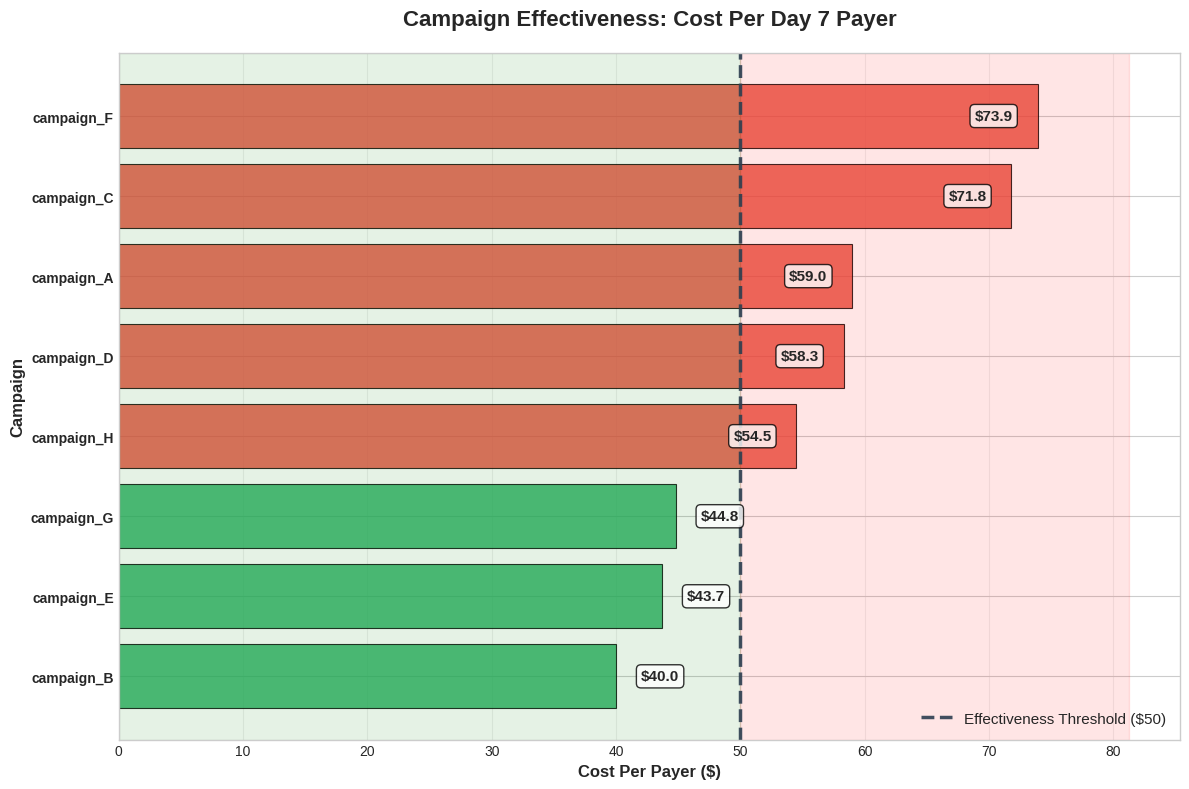

In [ ]:
def create_horizontal_campaign_viz(effectiveness_results):
    plt.figure(figsize=(12, 8))
    sorted_results = effectiveness_results.sort_values('CPP')
    colors = ['#27ae60' if cpp <= 50 else '#e74c3c' for cpp in sorted_results['CPP']]
    bars = plt.barh(range(len(sorted_results)), sorted_results['CPP'],
                    color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)
    plt.axvline(50, color='#2c3e50', linestyle='--', linewidth=2.5,
                label='Effectiveness Threshold ($50)', alpha=0.9)

    for i, (idx, row) in enumerate(sorted_results.iterrows()):
        cpp_value = row['CPP']
        x_offset = 2 if cpp_value <= 50 else -2
        ha = 'left' if cpp_value <= 50 else 'right'

        plt.text(cpp_value + x_offset, i, f'${cpp_value:.1f}',
                va='center', ha=ha, fontweight='bold', fontsize=11,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    plt.title('Campaign Effectiveness: Cost Per Day 7 Payer', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Cost Per Payer ($)', fontsize=12, fontweight='bold')
    plt.ylabel('Campaign', fontsize=12, fontweight='bold')
    plt.yticks(range(len(sorted_results)), sorted_results.index, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(axis='x', alpha=0.3)

    plt.axvspan(0, 50, alpha=0.1, color='green')
    plt.axvspan(50, max(sorted_results['CPP']) * 1.1, alpha=0.1, color='red')

    plt.tight_layout()
    return plt.gcf()


fig = create_horizontal_campaign_viz(effectiveness_results)
plt.show()

## Part 2: The Bigger Picture: Funnel Analysis and Long-Term Value

Does low initial CPP correlate with **higher long-term value**? What behaviors distinguish users from "**Effective**" versus "**Ineffective**" campaigns? We analyzed the **full conversion funnel** and **Average Revenue Per User (ARPU)** over **180 days**.

We compared the two campaign groups at each stage: ad click, registration, tutorial completion, and payment.

In [ ]:
effective_ad_data = ad_data[ad_data['campaign'].isin(effective_campaigns)]
ineffective_ad_data = ad_data[ad_data['campaign'].isin(ineffective_campaigns)]
effective_registration = registration[registration['campaign'].isin(effective_campaigns)]
ineffective_registration = registration[registration['campaign'].isin(ineffective_campaigns)]

effective_tutorial = tutorial[tutorial['id'].isin(effective_registration['id'])]
ineffective_tutorial = tutorial[tutorial['id'].isin(ineffective_registration['id'])]

day7_payers_effective_reg_df = registration[
    (registration['campaign'].isin(effective_campaigns)) &
    (registration['id'].isin(day7_payers_registration_df['id']))
]
day7_payers_ineffective_reg_df = registration[
    (registration['campaign'].isin(ineffective_campaigns)) &
    (registration['id'].isin(day7_payers_registration_df['id']))
]

effective_impressions = effective_ad_data['impressions'].sum()
effective_clicks = effective_ad_data['clicks'].sum()
ineffective_impressions = ineffective_ad_data['impressions'].sum()
ineffective_clicks = ineffective_ad_data['clicks'].sum()

effective_ctr = (effective_clicks / effective_impressions) if effective_impressions > 0 else 0
ineffective_ctr = (ineffective_clicks / ineffective_impressions) if ineffective_impressions > 0 else 0

# Calculate product funnel metrics
effective_registrations = effective_registration['id'].nunique()
ineffective_registrations = ineffective_registration['id'].nunique()

effective_reg_rate = (effective_registrations / effective_clicks) if effective_clicks > 0 else 0
ineffective_reg_rate = (ineffective_registrations / ineffective_clicks) if ineffective_clicks > 0 else 0

effective_tutorial_completions = effective_tutorial['id'].nunique()
ineffective_tutorial_completions = ineffective_tutorial['id'].nunique()

effective_tut_comp_rate = (effective_tutorial_completions / effective_registrations) if effective_registrations > 0 else 0
ineffective_tut_comp_rate = (ineffective_tutorial_completions / ineffective_registrations) if ineffective_registrations > 0 else 0

effective_day7_payers = day7_payers_effective_reg_df['id'].nunique()
ineffective_day7_payers = day7_payers_ineffective_reg_df['id'].nunique()

effective_day7_payer_rate = (effective_day7_payers / effective_registrations) if effective_registrations > 0 else 0
ineffective_day7_payer_rate = (ineffective_day7_payers / ineffective_registrations) if ineffective_registrations > 0 else 0

effective_overall_conversion = (effective_day7_payers / effective_clicks) if effective_clicks > 0 else 0
ineffective_overall_conversion = (ineffective_day7_payers / ineffective_clicks) if ineffective_clicks > 0 else 0

# Funnel comparison df
funnel_comparison = pd.DataFrame({
    'Campaign Group': ['Effective Campaigns', 'Ineffective Campaigns'],
    'Impressions': [effective_impressions, ineffective_impressions],
    'Clicks': [effective_clicks, ineffective_clicks],
    'CTR': [effective_ctr, ineffective_ctr],
    'Registrations': [effective_registrations, ineffective_registrations],
    'Registration Rate': [effective_reg_rate, ineffective_reg_rate],
    'Tutorial Completions': [effective_tutorial_completions, ineffective_tutorial_completions],
    'Tutorial Completion Rate': [effective_tut_comp_rate, ineffective_tut_comp_rate],
    'Day 7 Payers': [effective_day7_payers, ineffective_day7_payers],
    'Day 7 Payer Rate': [effective_day7_payer_rate, ineffective_day7_payer_rate],
    'Overall Conversion (Clicks→Pay)': [effective_overall_conversion, ineffective_overall_conversion]
})

print("Funnel Analysis: Effective vs Ineffective Campaigns")
print("=" * 50)
print(funnel_comparison.to_string(index=False))

Funnel Analysis: Effective vs Ineffective Campaigns
       Campaign Group  Impressions  Clicks      CTR  Registrations  Registration Rate  Tutorial Completions  Tutorial Completion Rate  Day 7 Payers  Day 7 Payer Rate  Overall Conversion (Clicks→Pay)
  Effective Campaigns       201276   88525 0.439819          15067           0.170201                  8114                  0.538528           740          0.049114                         0.008359
Ineffective Campaigns       309925  133830 0.431814          22077           0.164963                 10414                  0.471713           960          0.043484                         0.007173


### Deeper Insights: Journey vs. Destination

Funnel analysis revealed a **consistent pattern**:

-   **Smoother Journey:** Effective campaigns were **better at moving users through every stage**.
-   **Critical Milestone:** Tutorial completion showed a **significant gap 53.9%** for effective vs. **47.2%** for ineffective. This suggests the **tutorial is a key leverage point** for engagement and monetization.

ARPU analysis told a different, more **surprising story**.

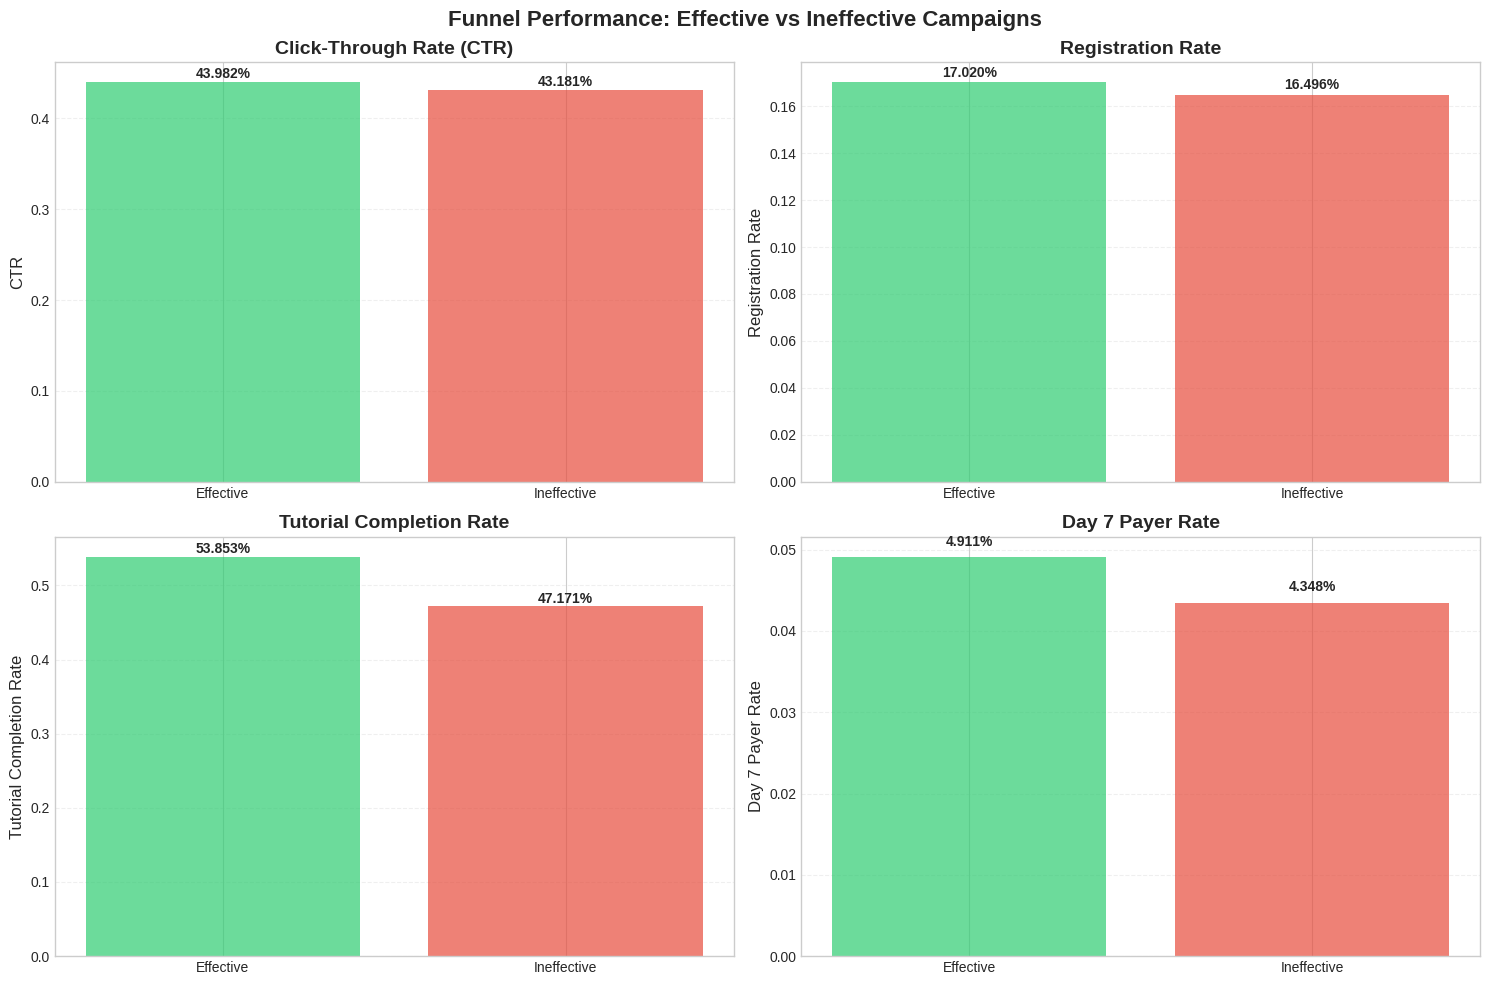

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

campaigns = ['Effective', 'Ineffective']
ctr_values = [funnel_comparison.loc[0, 'CTR'], funnel_comparison.loc[1, 'CTR']]
colors = ['#2ecc71', '#e74c3c']

bars1 = ax1.bar(campaigns, ctr_values, color=colors, alpha=0.7)
ax1.set_title('Click-Through Rate (CTR)', fontsize=14, fontweight='bold')
ax1.set_ylabel('CTR', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

for bar, value in zip(bars1, ctr_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.3%}', ha='center', va='bottom', fontweight='bold')

reg_rate_values = [funnel_comparison.loc[0, 'Registration Rate'], funnel_comparison.loc[1, 'Registration Rate']]
bars2 = ax2.bar(campaigns, reg_rate_values, color=colors, alpha=0.7)
ax2.set_title('Registration Rate', fontsize=14, fontweight='bold')
ax2.set_ylabel('Registration Rate', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.3)

for bar, value in zip(bars2, reg_rate_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.3%}', ha='center', va='bottom', fontweight='bold')

tut_rate_values = [funnel_comparison.loc[0, 'Tutorial Completion Rate'], funnel_comparison.loc[1, 'Tutorial Completion Rate']]
bars3 = ax3.bar(campaigns, tut_rate_values, color=colors, alpha=0.7)
ax3.set_title('Tutorial Completion Rate', fontsize=14, fontweight='bold')
ax3.set_ylabel('Tutorial Completion Rate', fontsize=12)
ax3.grid(axis='y', linestyle='--', alpha=0.3)

for bar, value in zip(bars3, tut_rate_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.3%}', ha='center', va='bottom', fontweight='bold')

payer_rate_values = [funnel_comparison.loc[0, 'Day 7 Payer Rate'], funnel_comparison.loc[1, 'Day 7 Payer Rate']]
bars4 = ax4.bar(campaigns, payer_rate_values, color=colors, alpha=0.7)
ax4.set_title('Day 7 Payer Rate', fontsize=14, fontweight='bold')
ax4.set_ylabel('Day 7 Payer Rate', fontsize=12)
ax4.grid(axis='y', linestyle='--', alpha=0.3)

for bar, value in zip(bars4, payer_rate_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.3%}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Funnel Performance: Effective vs Ineffective Campaigns', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### ARPU Analysis: Long-term Value Assessment

In [ ]:
# Merge registration and payment data for ARPU
merged_df = pd.merge(registration, payment, on='id', how='left')
merged_df['time_diff'] = (merged_df['pay_ts'] - merged_df['reg_ts']).dt.days

def calculate_arpu(merged_df, days):
  user_revenue_within_window = merged_df[merged_df['time_diff'] <= days].groupby('id')['payment'].sum().reset_index()
  user_revenue_within_window.rename(columns={'payment': f'total_revenue_{days}d'}, inplace=True)

  total_registered_users = merged_df.groupby('campaign')['id'].nunique().reset_index()
  total_registered_users.rename(columns={'id': 'total_users'}, inplace=True)

  campaign_revenue = merged_df[merged_df['time_diff'] <= days].groupby('campaign')['payment'].sum().reset_index()
  campaign_revenue.rename(columns={'payment': f'total_campaign_revenue_{days}d'}, inplace=True)

  arpu_calc_df = total_registered_users.merge(campaign_revenue, on='campaign', how='left').fillna(0)

  arpu_calc_df[f'{days} Days ARPU'] = arpu_calc_df[f'total_campaign_revenue_{days}d'] / arpu_calc_df['total_users']

  return arpu_calc_df[['campaign', f'{days} Days ARPU']].round(2)

# ARPU for multiple time windows
time_windows = [7, 14, 30, 90, 180]
arpu_results = []

for days in time_windows:
    arpu_df = calculate_arpu(merged_df, days)
    arpu_results.append(arpu_df)

arpu_report = arpu_results[0]
for arpu_df in arpu_results[1:]:
    arpu_report = arpu_report.merge(arpu_df, on='campaign', how='outer')

    arpu_report['effectiveness'] = arpu_report['campaign'].apply(
        lambda x: 'Effective' if x in effective_campaigns else 'Ineffective'
        )
print("ARPU Analysis by Campaign and Time Window")
print("=" * 50)
print(arpu_report.to_string(index=False))

ARPU Analysis by Campaign and Time Window
  campaign  7 Days ARPU  14 Days ARPU effectiveness  30 Days ARPU  90 Days ARPU  180 Days ARPU
campaign_A         0.52          0.74   Ineffective          1.11          2.97           3.92
campaign_B         0.29          0.34     Effective          0.44          0.54           0.54
campaign_C         0.33          0.47   Ineffective          0.73          1.72           2.65
campaign_D         1.80          2.14   Ineffective          2.49          3.45           3.45
campaign_E         0.75          1.07     Effective          1.75          3.03           4.37
campaign_F         0.39          0.49   Ineffective          0.70          2.18           2.95
campaign_G         0.50          0.72     Effective          1.18          2.26           2.98
campaign_H         0.31          0.50   Ineffective          0.87          1.56           2.20


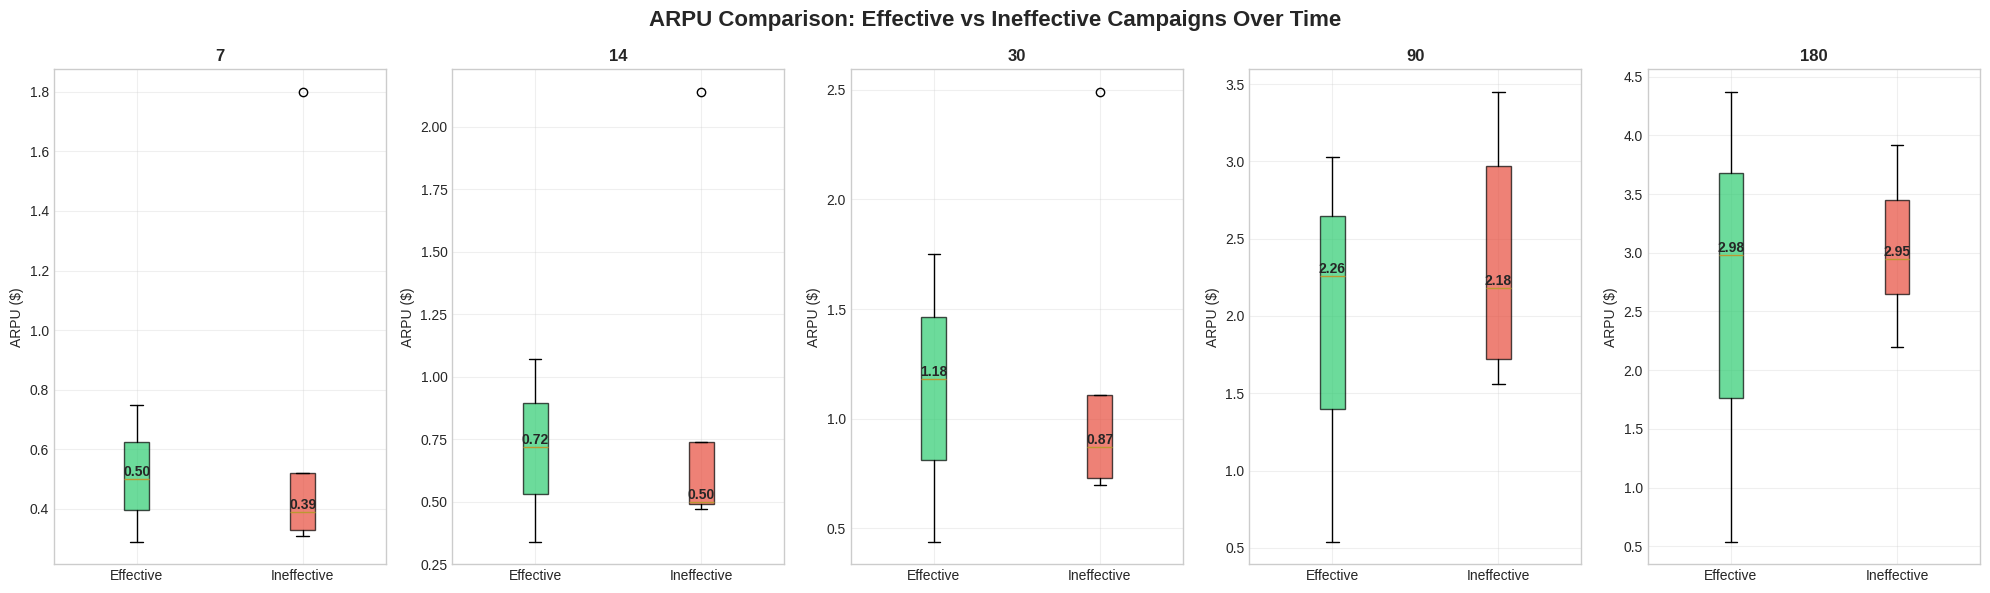

In [ ]:
# Viz ARPU by Effectiveness at Different Time Windows
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('ARPU Comparison: Effective vs Ineffective Campaigns Over Time', fontsize=16, fontweight='bold')

for i, window in enumerate(time_windows):
    ax = axes[i]
    arpu_column_name = f'{window} Days ARPU'
    effective_data = arpu_report[arpu_report['effectiveness'] == 'Effective'][arpu_column_name]
    ineffective_data = arpu_report[arpu_report['effectiveness'] == 'Ineffective'][arpu_column_name]

    bp = ax.boxplot([effective_data, ineffective_data],
                    labels=['Effective', 'Ineffective'],
                    patch_artist=True)

    colors = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_title(f'{window}', fontsize=12, fontweight='bold')
    ax.set_ylabel('ARPU ($)', fontsize=10)
    ax.grid(True, alpha=0.3)

    # You might want to add median values as text labels here
    for j, data in enumerate([effective_data, ineffective_data]):
        median_val = data.median()
        ax.text(j+1, median_val, f'{median_val:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10
                )

plt.tight_layout()
plt.show()

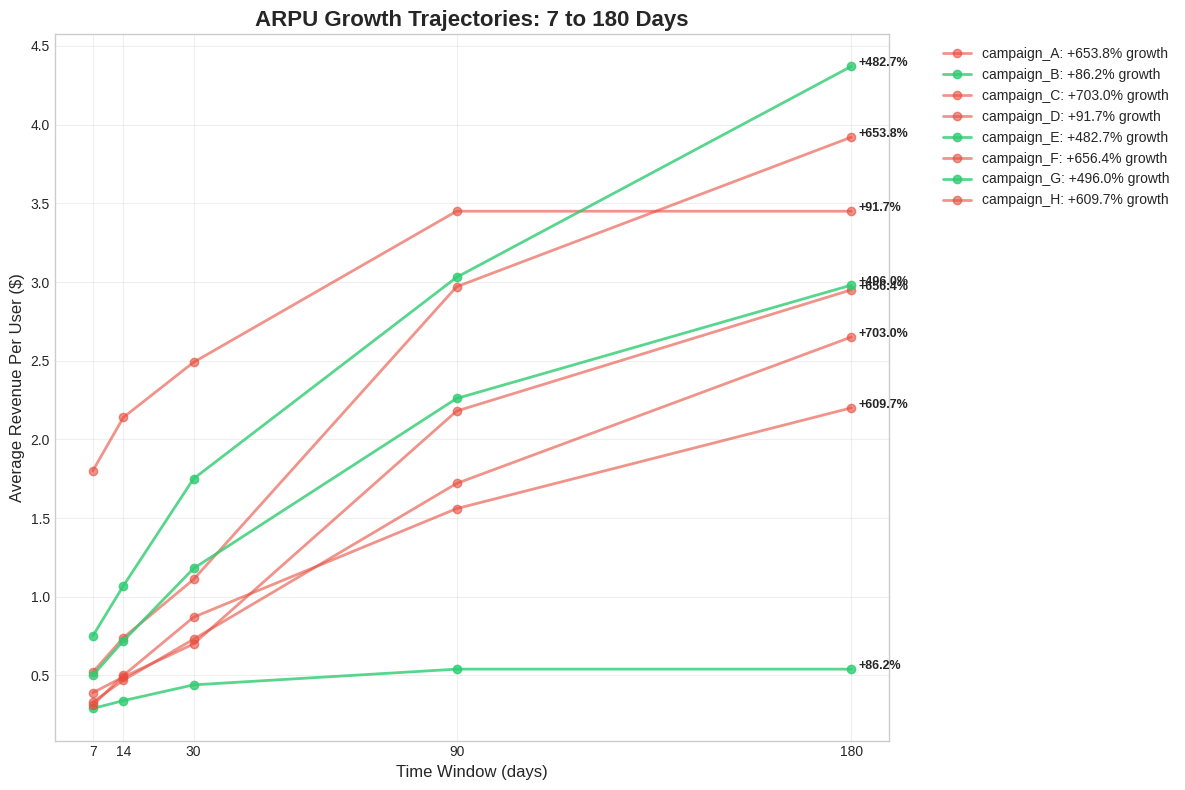

In [ ]:
# Viz ARPU Growth
plt.figure(figsize=(12, 8))

for campaign in arpu_report['campaign'].unique():
    campaign_data = arpu_report[arpu_report['campaign'] == campaign]
    effectiveness = campaign_data['effectiveness'].iloc[0]

    arpu_values = []
    for window in time_windows:
        arpu_column_name = f'{window} Days ARPU'
        arpu_values.append(campaign_data[arpu_column_name].iloc[0])

    initial_arpu = arpu_values[0]
    final_arpu = arpu_values[-1]
    growth_rate = ((final_arpu - initial_arpu) / initial_arpu) * 100 if initial_arpu > 0 else 0

    if effectiveness == 'Effective':
        color = '#2ecc71'
        alpha = 0.8
    else:
        color = '#e74c3c'
        alpha = 0.6

    plt.plot(time_windows, arpu_values, marker='o', linewidth=2, markersize=6,
             color=color, alpha=alpha,
             label=f'{campaign}: {growth_rate:+.1f}% growth')

    plt.annotate(f'{growth_rate:+.1f}%',
                (time_windows[-1], arpu_values[-1]),
                xytext=(5, 0), textcoords='offset points',
                fontsize=9, fontweight='bold')

plt.title('ARPU Growth Trajectories: 7 to 180 Days', fontsize=16, fontweight='bold')
plt.xlabel('Time Window (days)', fontsize=12)
plt.ylabel('Average Revenue Per User ($)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(time_windows, [f'{window}' for window in time_windows])
plt.tight_layout()
plt.show()

-   **Long-Term Value Emerges:** Campaigns A and C ("Ineffective") demonstrated **strong and sustained ARPU growth**.
-   **"Quick Win" Fades:** Campaign B ("Effective") showed **relatively flat long-term ARPU growth**.

This discovery is **crucial**. Focusing only on the first payment can obscure **true Lifetime Value (LTV)** (source: [How OWOX BI Built & Optimized a Custom Marketing Attribution Model for SaaS Business](https://www.owox.com/blog/use-cases/attribution-for-saas-b2b)). It suggests some "**ineffective**" campaigns acquire users with **higher long-term potential**, forcing us to reconsider success.

## Part 3. Statistical Validation: Ensuring Our Insights are Real

Campaign E (CPP \$43.70) appeared more effective than Campaign H (CPP \$89.23). Are such differences **statistically significant** or random chance?

To validate, we designed a **hypothesis test**. **Null hypothesis (H₀)**: **no real difference** in 7-day payment behavior between Campaign E and H users. **Alternative hypothesis (H₁)**: a **true difference exists**.

Given skewed payment data, we chose the **non-parametric Mann-Whitney U test**, α at **0.05** (95% confidence).

In [ ]:
registration_E = registration[registration['campaign'] == 'campaign_E']
registration_H = registration[registration['campaign'] == 'campaign_H']

merged_reg_pay_E = pd.merge(registration_E, payment, on='id', how='inner')
merged_reg_pay_H = pd.merge(registration_H, payment, on='id', how='inner')

merged_reg_pay_E['lifetime'] = merged_reg_pay_E['pay_ts'] - merged_reg_pay_E['reg_ts']
merged_reg_pay_H['lifetime'] = merged_reg_pay_H['pay_ts'] - merged_reg_pay_H['reg_ts']

day7_payments_E = merged_reg_pay_E[merged_reg_pay_E['lifetime'] <= pd.Timedelta(days=7)]
day7_payments_H = merged_reg_pay_H[merged_reg_pay_H['lifetime'] <= pd.Timedelta(days=7)]

total_revenue_E = day7_payments_E['payment'].sum()
num_users_E = registration_E['id'].nunique()
arpu_7_E = total_revenue_E / num_users_E if num_users_E > 0 else 0

total_revenue_H = day7_payments_H['payment'].sum()
num_users_H = registration_H['id'].nunique()
arpu_7_H = total_revenue_H / num_users_H if num_users_H > 0 else 0

print("ARPU7 Comparison: Campaigns E vs H")
print("=" * 50)
print(f"Campaign E ARPU7: ${arpu_7_E:.2f}")
print(f"Campaign H ARPU7: ${arpu_7_H:.2f}")
print(f"Difference: ${arpu_7_E - arpu_7_H:.2f} ({((arpu_7_E - arpu_7_H)/arpu_7_H*100):.1f}%)")

ARPU7 Comparison: Campaigns E vs H
Campaign E ARPU7: $0.68
Campaign H ARPU7: $0.29
Difference: $0.39 (133.7%)


In [ ]:
all_users_E = registration[registration['campaign'] == 'campaign_E']['id'].unique()
all_users_H = registration[registration['campaign'] == 'campaign_H']['id'].unique()

user_payments_E = merged_reg_pay_E[merged_reg_pay_E['lifetime'] <= pd.Timedelta(days=7)].groupby('id')['payment'].sum().reset_index()
user_payments_E.rename(columns={'payment': '7_day_payment'}, inplace=True)

user_arpu_E_df = pd.DataFrame({'id': all_users_E})
user_arpu_E_df = pd.merge(user_arpu_E_df, user_payments_E, on='id', how='left').fillna(0)
user_arpu_E = user_arpu_E_df['7_day_payment'].values

user_payments_H = merged_reg_pay_H[merged_reg_pay_H['lifetime'] <= pd.Timedelta(days=7)].groupby('id')['payment'].sum().reset_index()
user_payments_H.rename(columns={'payment': '7_day_payment'}, inplace=True)

user_arpu_H_df = pd.DataFrame({'id': all_users_H})
user_arpu_H_df = pd.merge(user_arpu_H_df, user_payments_H, on='id', how='left').fillna(0)
user_arpu_H = user_arpu_H_df['7_day_payment'].values


# Shapiro-Wilk test for normality
shapiro_E_stat, shapiro_E_p = stats.shapiro(user_arpu_E)
shapiro_H_stat, shapiro_H_p = stats.shapiro(user_arpu_H)

print("Shapiro-Wilk Test for Normality (7-Day User Payments)")
print("=" * 50)
print(f"Campaign E: Statistic={shapiro_E_stat:.4f}, p-value={shapiro_E_p:.4f}")
print(f"Campaign H: Statistic={shapiro_H_stat:.4f}, p-value={shapiro_H_p:.4f}")
print("\nInterpretation: \nIf p-value < 0.05, reject null hypothesis of normality.")


# Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(user_arpu_E, user_arpu_H, alternative='two-sided')

print("\nMann-Whitney U Test (Comparing 7-Day User Payments)")
print("=" * 50)
print(f"U Statistic: {u_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: \nReject the null hypothesis. \nThere is a statistically significant difference (p < {alpha}) in the 7-day payment distributions between Campaign E and Campaign H.")
else:
    print(f"\nConclusion: \nFail to reject the null hypothesis. \nThere is no statistically significant difference (p >= {alpha}) in the 7-day payment distributions between Campaign E and Campaign H.")

Shapiro-Wilk Test for Normality (7-Day User Payments)
Campaign E: Statistic=0.0307, p-value=0.0000
Campaign H: Statistic=0.0137, p-value=0.0000

Interpretation: 
If p-value < 0.05, reject null hypothesis of normality.

Mann-Whitney U Test (Comparing 7-Day User Payments)
U Statistic: 66360671.00
P-value: 0.0007

Conclusion: 
Reject the null hypothesis. 
There is a statistically significant difference (p < 0.05) in the 7-day payment distributions between Campaign E and Campaign H.


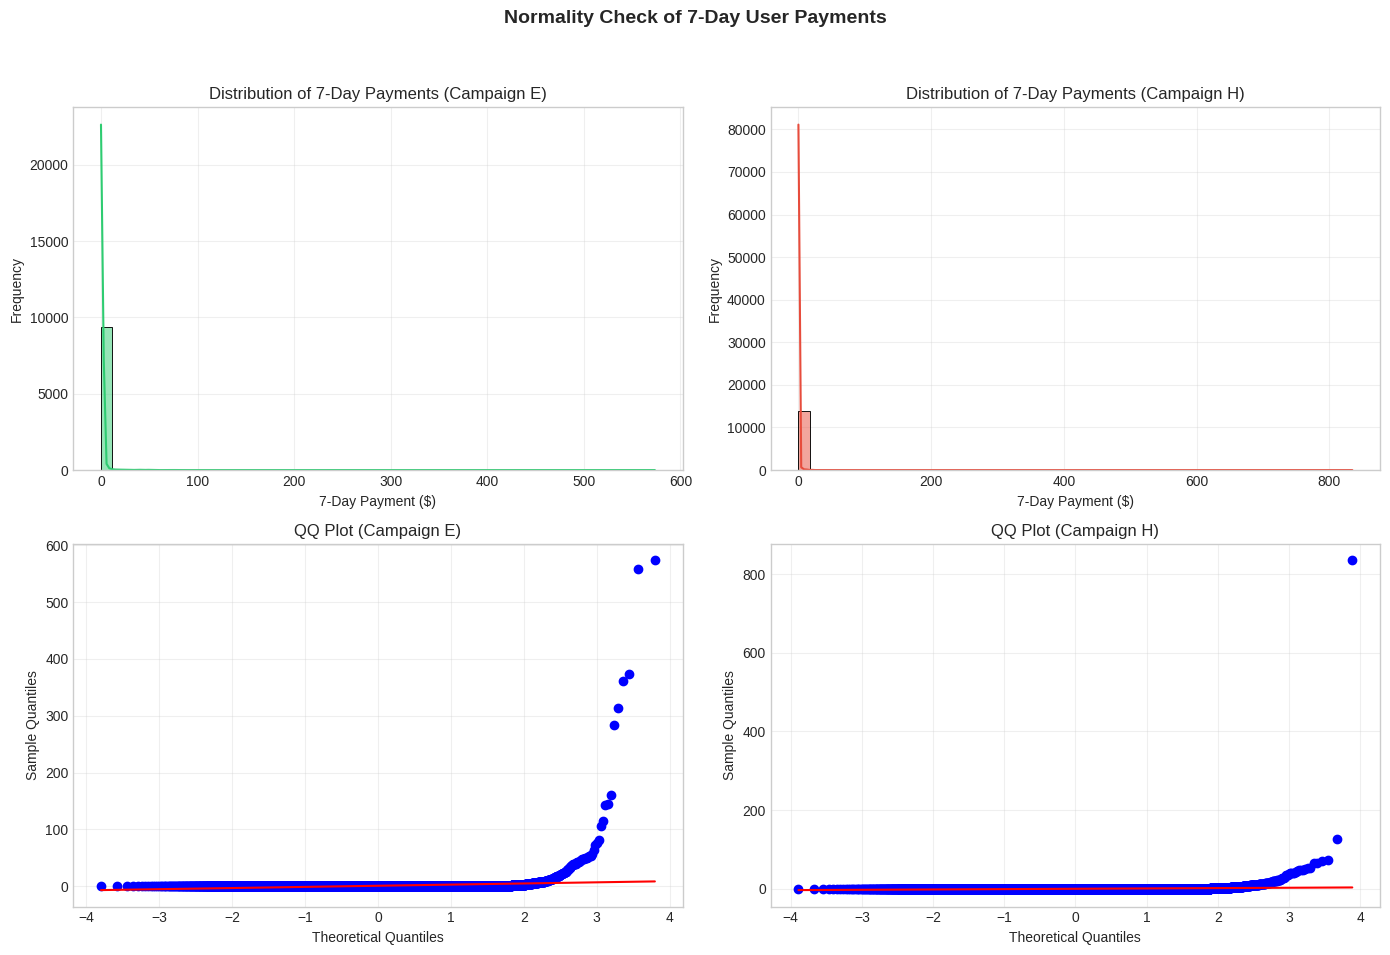

In [ ]:
# Visualize Normality and QQ plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograms
sns.histplot(user_arpu_E, ax=axes[0, 0], color='#2ecc71', kde=True, bins=50)
axes[0, 0].set_title('Distribution of 7-Day Payments (Campaign E)', fontsize=12)
axes[0, 0].set_xlabel('7-Day Payment ($)', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

sns.histplot(user_arpu_H, ax=axes[0, 1], color='#e74c3c', kde=True, bins=50)
axes[0, 1].set_title('Distribution of 7-Day Payments (Campaign H)', fontsize=12)
axes[0, 1].set_xlabel('7-Day Payment ($)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# QQ Plots
stats.probplot(user_arpu_E, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('QQ Plot (Campaign E)', fontsize=12)
axes[1, 0].set_xlabel('Theoretical Quantiles', fontsize=10)
axes[1, 0].set_ylabel('Sample Quantiles', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

stats.probplot(user_arpu_H, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('QQ Plot (Campaign H)', fontsize=12)
axes[1, 1].set_xlabel('Theoretical Quantiles', fontsize=10)
axes[1, 1].set_ylabel('Sample Quantiles', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Normality Check of 7-Day User Payments', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### The Verdict: Difference is Real

The test returned a **p-value well below 0.05**. This provides **strong statistical evidence** to reject H₀. We confidently conclude Campaign E is **genuinely more effective** than Campaign H at driving monetization within 7 days. This validates our initial classification and provides a solid foundation for budget allocation decisions between these two campaigns.

## Part 4. Strategic Experimentation: Designing an A/B Test

Armed with insights, we move from analysis to **action**. Proposed: a **new creative variant** for Campaign E, hypothesizing a **20% increase in 3-day conversion rate**. To test rigorously, we designed an **A/B test**.

-   **Hypothesis:** New creative outperforms existing Campaign E creative, leading to a **20% relative uplift** in **Day-3 registration-to-payment conversion rate**.
-   **Control Group (A):** Users exposed to current Campaign E.
-   **Test Group (B):** Users exposed to new creative variant.
-   **Primary Metric:** Day 3 conversion rate.
-   **Statistical Goals:** **80% power** to detect 20% uplift, α of **5%**.

In [ ]:
# Calculate baseline Day 3 conversion rate for Campaign E
registration_E = registration[registration['campaign'] == 'campaign_E']
merged_reg_pay_E = pd.merge(registration_E, payment, on='id', how='inner')
merged_reg_pay_E['lifetime'] = merged_reg_pay_E['pay_ts'] - merged_reg_pay_E['reg_ts']

day3_payments_E = merged_reg_pay_E[merged_reg_pay_E['lifetime'] <= pd.Timedelta(days=3)]
day3_payers_E_count = day3_payments_E['id'].nunique()
total_registrations_E = registration_E['id'].nunique()

baseline_day3_conversion_rate = day3_payers_E_count / total_registrations_E if total_registrations_E > 0 else 0

desired_relative_uplift = 0.20
target_day3_conversion_rate = baseline_day3_conversion_rate * (1 + desired_relative_uplift)

print("A/B Test Parameters")
print("=" * 50)
print(f"Baseline Day 3 Conversion Rate: {baseline_day3_conversion_rate:.4f} ({baseline_day3_conversion_rate:.2%})")
print(f"Target Day 3 Conversion Rate: {target_day3_conversion_rate:.4f} ({target_day3_conversion_rate:.2%})")
print(f"Desired Uplift: {desired_relative_uplift:.1%}")

# Calculate effect size for a one-sided test expecting an increase
effect_size = proportion_effectsize(baseline_day3_conversion_rate, target_day3_conversion_rate)
# Ensure effect size is positive for the 'larger' alternative
effect_size = abs(effect_size)

alpha = 0.05
power = 0.80

# 1-sided test since we're testing for improvement
sample_size_needed_per_group = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative='larger'
)

total_sample_size_needed = sample_size_needed_per_group * 2

print(f"\nSample Size Calculation")
print("=" * 50)
print(f"Effect Size: {effect_size:.4f}")
print(f"Statistical Power: {power:.1%}")
print(f"Significance Level: {alpha:.1%}")
print(f"Required Sample Size per Group: {sample_size_needed_per_group:.0f}")
print(f"Total Sample Size (both groups): {total_sample_size_needed:.0f}")

# Estimate test duration, assuming 1000 daily registrations. Should be adjusted based on actual traffic
estimated_daily_registrations = 1000
estimated_days = total_sample_size_needed / estimated_daily_registrations

print(f"\nTest Duration Estimate")
print("=" * 50)
print(f"Assumed Daily Registrations: {estimated_daily_registrations:,}")
print(f"Estimated Test Duration: {estimated_days:.1f} days")

A/B Test Parameters
Baseline Day 3 Conversion Rate: 0.0417 (4.17%)
Target Day 3 Conversion Rate: 0.0500 (5.00%)
Desired Uplift: 20.0%

Sample Size Calculation
Effect Size: 0.0399
Statistical Power: 80.0%
Significance Level: 5.0%
Required Sample Size per Group: 7764
Total Sample Size (both groups): 15527

Test Duration Estimate
Assumed Daily Registrations: 1,000
Estimated Test Duration: 15.5 days


This experiment allows a **data-driven decision**. We will monitor key funnel metrics to ensure the new variant doesn't negatively impact other behaviors. Success is defined by a statistically significant lift in our primary metric and absence of negative secondary effects.

## Part 5. Cohort Deep Dive: Tracking Player Value with SQL

To further explore long-term value, we used **SQL** for a **targeted cohort analysis**. We isolated a **high-potential user group** players registered May 10-20 who completed the tutorial within 7 days tracking their **cumulative revenue over 100 days**.

This approach moves beyond campaign averages to understand the **LTV trajectory of a specific, engaged user segment**.

In [ ]:
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

registration.to_sql('registration', conn, index=False, if_exists='replace')
tutorial.to_sql('tutorial', conn, index=False, if_exists='replace')
payment.to_sql('payment', conn, index=False, if_exists='replace')

sql_query = """
WITH cohort AS (
    SELECT
        r.id,
        r.reg_ts,
        t.tut_ts
    FROM registration r
    JOIN tutorial t ON r.id = t.id
    WHERE r.date BETWEEN '2020-05-10' AND '2020-05-20'
        AND CAST((strftime('%s', t.tut_ts) - strftime('%s', r.reg_ts)) AS REAL) / (60 * 60) <= 168
),

payments AS (
    SELECT
        p.id,
        p.date AS date_pay,
        p.payment,
        CAST(strftime('%J', p.pay_ts) AS INTEGER) - CAST(strftime('%J', c.reg_ts) AS INTEGER) AS dar
    FROM payment p
    JOIN cohort c ON p.id = c.id
    WHERE CAST((strftime('%s', p.pay_ts) - strftime('%s', c.reg_ts)) AS REAL) / (60 * 60 * 24) <= 100
)

SELECT
    dar,
    SUM(payment) OVER (ORDER BY dar) AS revenue
FROM payments
GROUP BY dar
ORDER BY dar
"""

result_df = pd.read_sql_query(sql_query, conn)

print("Cohort Analysis: Cumulative Revenue Over 100 Days")
print("=" * 50)
print(result_df.head(10))

conn.close()

Cohort Analysis: Cumulative Revenue Over 100 Days
   dar   revenue
0    0  0.265862
1    1  0.696989
2    2  1.516430
3    3  1.954045
4    4  2.144192
5    5  2.647320
6    6  3.726996
7    7  4.225959
8    8  5.003428
9    9  5.446836


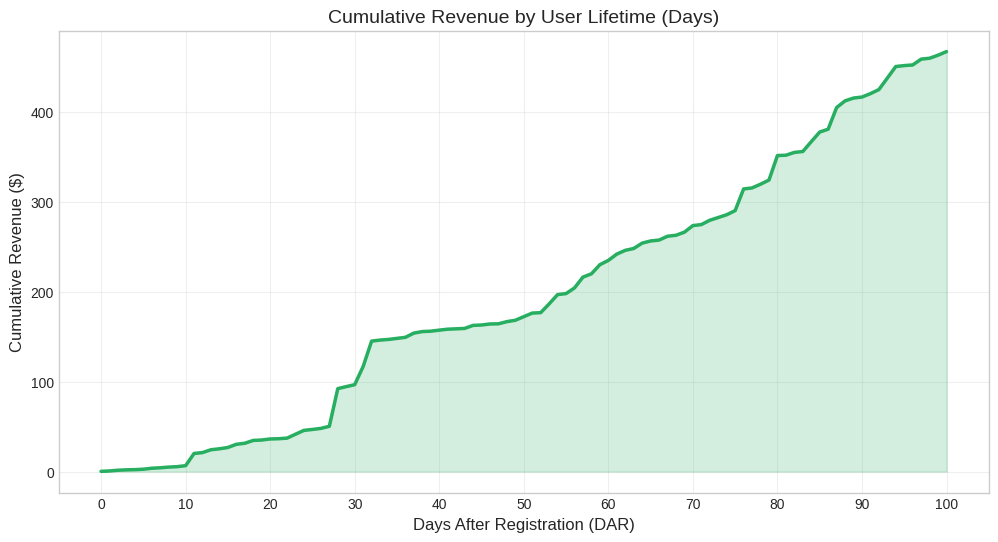

In [ ]:
# Viz for Cumulative Revenue by User Lifetime

plt.figure(figsize=(12, 6))
sns.lineplot(
    x='dar',
    y='revenue',
    data=result_df,
    color='#27ae60',
    linewidth=2.5
)
plt.fill_between(result_df['dar'], result_df['revenue'], alpha=0.2, color='#27ae60')
plt.title('Cumulative Revenue by User Lifetime (Days)', fontsize=14)
plt.xlabel('Days After Registration (DAR)', fontsize=12)
plt.ylabel('Cumulative Revenue ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 101, 10))
plt.show()

## 6. Strategic Insights & Actionable Recommendations

This analysis moves from simple ad costs to a **sophisticated understanding of player value**. Findings coalesce into **three core strategic insights**.

### Key Strategic Insights

1.  **Simple Metrics are a Starting Point, Not the Destination:** Relying solely on a short-term, first-touch metric like Day 7 CPP is insufficient. It identified quick wins but missed the high long-term value of Campaigns A and C.
2.  **Trade-Off: Acquisition Speed vs. Long-Term Value:** Some campaigns (G) excel at low-cost, immediate payers. Others (A, C) are "slow burn" investments cultivating higher-spending players. A healthy portfolio needs both.
3.  **Tutorial: Critical Monetization Gateway:** Significant drop-off at the tutorial stage, especially for less effective campaigns, pinpoints it as a high-impact area for optimization. Improving completion directly levers overall payer conversion.

### Actionable Recommendations

Based on these insights:

1.  **Evolve Budgeting Model:** Shift from pure CPP to a **hybrid performance model**.
    *   *"Sprinter"* Campaigns (G, E): Continue funding for efficient, short-term acquisition.
    *   *"Marathon"* Campaigns (A, C): Allocate budget optimizing for 90-day or 180-day LTV.
    *   *De-prioritize* (D, F, H): Re-evaluate and likely defund.
2.  **Investigate Advanced Attribution:** Our model is too simplistic. Dedicate resources to exploring sophisticated models for a truer picture. Failing to do so can result in misaligned spend and lost revenue (source: [blog.mystrika.com](blog.mystrika.com)). Compare models like:
    *   **Time-Decay:** More credit to touchpoints closer to conversion.
    *   **J-Shaped:** Importance of both first and last touch (source: [blog.hubxpert.com](blog.hubxpert.com)).
    Regularly compare results across models (recommendation: [seerinteractive.com](seerinteractive.com)).
3.  **Launch Funnel Optimization:** Make improving tutorial completion a cross-functional priority. Use data from "Effective" campaigns to understand successful onboarding.
4.  **Proceed with A/B Test:** Immediately launch the planned test on Campaign E. Success provides a more efficient "Sprinter" campaign.

By implementing these recommendations, we transition from measuring ad performance to strategically managing a portfolio delivering both immediate returns and sustainable, long-term growth.